In [1]:
%matplotlib inline
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from model import Model
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.4/runpy.py", line 170, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.4/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.4/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.4/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.4/dist-packages/tornado/platf

In [2]:
DATASET_PATH = 'dataset'

epochs = 12
LearningRate = 1e-3
BatchSize = 32
IMG_DIMS = (96, 96, 3)

imagePaths = sorted(list(paths.list_images(DATASET_PATH)))
random.seed(42)
random.shuffle(imagePaths)
print(imagePaths)

['dataset/blue_dress/00000381.jpeg', 'dataset/red_shirt/00000092.png', 'dataset/blue_jeans/00000056.jpg', 'dataset/blue_dress/00000163.jpg', 'dataset/red_dress/00000098.jpg', 'dataset/red_dress/00000007.jpg', 'dataset/blue_shirt/00000270.jpg', 'dataset/black_jeans/00000028.jpg', 'dataset/blue_shirt/00000385.jpeg', 'dataset/red_shirt/00000029.jpg', 'dataset/blue_jeans/00000114.jpeg', 'dataset/red_dress/00000176.jpg', 'dataset/red_shirt/00000051.jpg', 'dataset/blue_dress/00000374.jpg', 'dataset/black_jeans/00000318.jpg', 'dataset/red_dress/00000121.jpg', 'dataset/red_dress/00000259.jpg', 'dataset/blue_shirt/00000108.jpg', 'dataset/blue_jeans/00000370.jpeg', 'dataset/red_shirt/00000317.jpg', 'dataset/blue_dress/00000135.jpg', 'dataset/red_dress/00000231.jpg', 'dataset/red_dress/00000239.jpg', 'dataset/blue_shirt/00000144.JPG', 'dataset/blue_shirt/00000232.jpg', 'dataset/red_dress/00000268.jpg', 'dataset/blue_jeans/00000351.jpg', 'dataset/black_jeans/00000019.jpg', 'dataset/blue_jeans/0000

In [3]:
data = []
labels = []

for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMG_DIMS[1], IMG_DIMS[0]))
    image = img_to_array(image)
    data.append(image)
    
    # labels list
    l = label = imagePath.split(os.path.sep)[-2].split("_")
    labels.append(l)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

print(data)
print('----------------------------------')
print(labels)

[[[[0.98431373 0.98039216 0.98039216]
   [0.98431373 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   ...
   [0.97254902 0.96470588 0.96470588]
   [0.97254902 0.96470588 0.96470588]
   [0.97254902 0.96470588 0.96470588]]

  [[0.98039216 0.98039216 0.98039216]
   [0.98039216 0.98039216 0.98039216]
   [0.98823529 0.98039216 0.98039216]
   ...
   [0.97254902 0.96470588 0.96470588]
   [0.97254902 0.96470588 0.96470588]
   [0.97254902 0.96470588 0.96470588]]

  [[0.98823529 0.98039216 0.98039216]
   [0.98823529 0.98039216 0.98039216]
   [0.98823529 0.98039216 0.98039216]
   ...
   [0.97254902 0.96470588 0.96470588]
   [0.96862745 0.96078431 0.96078431]
   [0.96862745 0.96078431 0.96078431]]

  ...

  [[0.95294118 0.94509804 0.94509804]
   [0.94509804 0.9372549  0.9372549 ]
   [0.94901961 0.94117647 0.94117647]
   ...
   [0.9254902  0.91764706 0.91764706]
   [0.9254902  0.91764706 0.91764706]
   [0.9254902  0.91764706 0.91764706]]

  [[0.94509804 0.9372549  0.9372549 ]
   [0.9

In [4]:
print(" Class labels:")
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(labels)

# loop over each of the possible class labels and show them
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i + 1, label))

 Class labels:
1. black
2. blue
3. dress
4. jeans
5. red
6. shirt


In [5]:
aug = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
    )


In [6]:
model = Model.model(IMG_DIMS[1], IMG_DIMS[0], IMG_DIMS[2], len(mlb.classes_))
opt = Adam(lr=LearningRate, decay=LearningRate / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)

H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size = BatchSize),
    validation_data=(testX, testY),
    steps_per_epoch = len(trainX) // BatchSize,
    epochs = epochs,
    verbose=1
    )

model.save('fashion.model')

Epoch 1/12
54/54 [==============================] - 92s 2s/step - loss: 0.4042 - acc: 0.8483 - val_loss: 0.1965 - val_acc: 0.9450
Epoch 2/12
54/54 [==============================] - 88s 2s/step - loss: 0.2539 - acc: 0.9168 - val_loss: 0.1985 - val_acc: 0.9315
Epoch 3/12
54/54 [==============================] - 94s 2s/step - loss: 0.2344 - acc: 0.9224 - val_loss: 0.1851 - val_acc: 0.9442
Epoch 4/12
54/54 [==============================] - 87s 2s/step - loss: 0.2149 - acc: 0.9272 - val_loss: 0.1214 - val_acc: 0.9600
Epoch 5/12
54/54 [==============================] - 87s 2s/step - loss: 0.1759 - acc: 0.9386 - val_loss: 0.0909 - val_acc: 0.9669
Epoch 6/12
54/54 [==============================] - 87s 2s/step - loss: 0.1475 - acc: 0.9452 - val_loss: 0.1053 - val_acc: 0.9634
Epoch 7/12
54/54 [==============================] - 90s 2s/step - loss: 0.1402 - acc: 0.9525 - val_loss: 0.0916 - val_acc: 0.9638
Epoch 8/12
54/54 [==============================] - 88s 2s/step - loss: 0.1349 - acc: 0.95

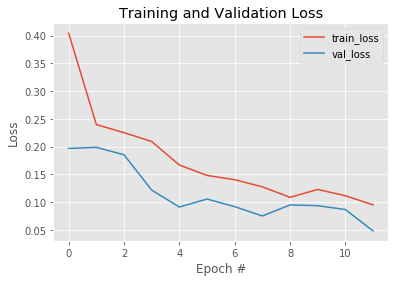

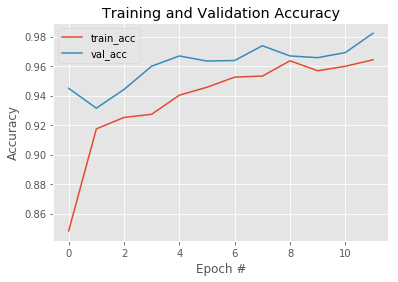

In [7]:
plt.style.use("ggplot")
N = epochs
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.figure()
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")

In [8]:
f = open("mlb.pickle", "wb")
f.write(pickle.dumps(mlb))
f.close()